This was my first at generating digits, I just came up with a simple idea where I first train a trivial autoencoder and a classifier, and then gradient descent the latent representation, with the loss function being classifier output on the decoded latent.

/var/folders/dv/s4d_k5012nn6c2dtg0chmxsc0000gn/T/ipykernel_41520/2746906529.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load('auto

Models loaded from disk!
Generating sample 1/10...
Generating sample 2/10...
Generating sample 3/10...
Generating sample 4/10...
Generating sample 5/10...
Generating sample 6/10...
Generating sample 7/10...
Generating sample 8/10...
Generating sample 9/10...
Generating sample 10/10...


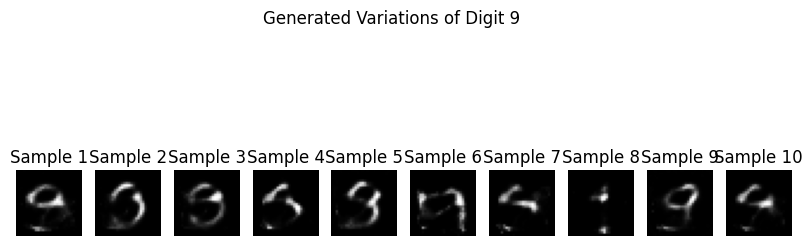

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import os

# Hyperparameters
latent_dim = 16
lr = 0.1
target_class = 9  # Change this to generate different digits
steps = 1000      # Optimization steps per generation
num_samples = 10   # Number of distinct samples to generate
noise_scale = 0.1 # Scale of noise for perturbation
ae_steps = 30     # Autoencoder training epochs
cl_steps = 30     # Classifier training epochs

# Autoencoder Architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 784)
        z = self.encoder(x)
        return self.decoder(z)

# Classifier Architecture
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.model(x)

# Load MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)

# Initialize models
autoencoder = Autoencoder()
classifier = Classifier()

# Check if models are already saved
if os.path.exists('autoencoder.pth') and os.path.exists('classifier.pth'):
    # Load saved models
    autoencoder.load_state_dict(torch.load('autoencoder.pth'))
    classifier.load_state_dict(torch.load('classifier.pth'))
    print("Models loaded from disk!")
else:
    # Train Autoencoder
    ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
    for epoch in range(ae_steps):
        for images, _ in train_loader:
            ae_optimizer.zero_grad()
            reconstructions = autoencoder(images)
            loss = nn.MSELoss()(reconstructions, images.view(-1, 784))
            loss.backward()
            ae_optimizer.step()
        print(f"AE Epoch {epoch+1}, Loss: {loss.item():.4f}")

    # Train Classifier
    cls_optimizer = optim.Adam(classifier.parameters(), lr=0.001)
    for epoch in range(cl_steps):
        for images, labels in train_loader:
            cls_optimizer.zero_grad()
            outputs = classifier(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            cls_optimizer.step()
        print(f"Classifier Epoch {epoch+1}, Loss: {loss.item():.4f}")

    # Save models to disk
    torch.save(autoencoder.state_dict(), 'autoencoder.pth')
    torch.save(classifier.state_dict(), 'classifier.pth')
    print("Models saved to disk!")

# Freeze models
for model in [autoencoder, classifier]:
    for param in model.parameters():
        param.requires_grad = False

# Function to generate a digit with noise perturbation
def generate_digit(target_class, noise_scale=0.1):
    # Initialize latent vector with noise
    z = torch.randn(1, latent_dim) + noise_scale * torch.randn(1, latent_dim)
    z.requires_grad_(True)  # Make z require gradients
    
    optimizer = optim.Adam([z], lr=lr)
    
    for step in range(steps):
        optimizer.zero_grad()
        
        # Generate image from latent vector
        generated = autoencoder.decoder(z)
        
        # Get classifier predictions
        logits = classifier(generated)
        
        # Maximize probability for target class
        loss = nn.CrossEntropyLoss()(logits, torch.tensor([target_class]))
        
        # Backpropagate
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        generated_img = autoencoder.decoder(z).view(28, 28).numpy()
    
    return generated_img

# Generate multiple distinct samples
generated_images = []
for i in range(num_samples):
    print(f"Generating sample {i+1}/{num_samples}...")
    img = generate_digit(target_class, noise_scale=noise_scale)
    generated_images.append(img)

# Visualize results
plt.figure(figsize=(10, 4))
for i, img in enumerate(generated_images):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Sample {i+1}")
    plt.axis('off')
plt.suptitle(f"Generated Variations of Digit {target_class}")
plt.show()